Imports

In [108]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


Importing the csv file

In [109]:
df = pd.read_csv('Final_News_DF_Labeled_ExamDataset.csv')
print(df.head())
print(df.iloc[1])

      LABEL  according  agency  ahead  alabama  amazon  america  american  \
0  politics          0       0      0        0       0        0         0   
1  politics          0       0      0        0       0        0         0   
2  politics          0       0      0        0       0        0         0   
3  politics          0       0      0        0       0        0         0   
4  politics          0       0      0        0       0        0         0   

   announced  appeared  ...  wolverines  women  work  working  world  wrote  \
0          1         0  ...           0      0     0        0      0      0   
1          0         0  ...           0      0     0        0      0      0   
2          0         0  ...           0      0     0        0      0      0   
3          0         0  ...           0      0     0        0      0      0   
4          0         0  ...           0      0     0        0      0      0   

   year  years  york  young  
0     0      0     0      0  
1 

After looking at the data the first step is to process the data. From printing the first row I notice that each row is the words used in the article, however it only states whoch words are used and not the order they occur in which I will get back to when evaluating the models. The second thing I noticed is that the Labels are categorical, meaning they are constructed out of words which is not interpretable by a computer. Therefore I need to give the labels a numeric value. I did this by first seperating the label column into a variable named y. I then needed to reshape it so that it specified that it only has one column before giving to scikit learns one hot encoder, which gives each category a vector representation. 

I also know that all other columns than LABELS is the words from an article, which is what I need in order restructure the artcicle in question. Hence, I simply used all columns except LABELS and stored them in a variable named X, which will be a training and testing data. 



The result from one hot encoding is that fotball is repsented as [1 0 0], potitcs is represneted as [0. 1. 0.] and science is represented as [0. 0 1]. This can be seen in the prints underneath the next block of code. 



In [152]:
from sklearn.preprocessing import OneHotEncoder

y = df['LABEL']

y = y.values.reshape(-1, 1)

unique_categories = np.unique(y)

print(f'These are the different categories int the dataset {unique_categories}')


encoder = OneHotEncoder(sparse_output=False)

one_hot_encoding = encoder.fit_transform(y)
unique_vectors = np.unique(one_hot_encoding, axis=0)


print(f'These are the unique values after one hot \n {unique_vectors}')

X = df.drop('LABEL', axis=1)



These are the different categories int the dataset ['football' 'politics' 'science']
These are the unique values after one hot 
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


Next step is go split the data up into training and testing, training will be used to learn the model to see patterns and the testing data will be used to evaluate the models performance. I did this by utilizing sklearns function for test train split, which randomizes the data and seperate them. In this case I choose a random state of 42 which comes from experience for a good random state and the test size to be 30%, which also comes from experience. 

After spliting up the data we can se the shapes for both traning and testing. We see that we have 1045 traning samples and 448 testing samples, 300 is the number of words used in the articles. 

In [111]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, one_hot_encoding, random_state=42, test_size=0.3)

print(f'The traning data has the following shapes: {x_train.shape}')
print(f'The traning data has the following shapes: {x_test.shape}')

The traning data has the following shapes: (1045, 300)
The traning data has the following shapes: (448, 300)


Now we are ready to train the models, we start with the ANN model. I start by setting the expected shape for the model, which is the number of different words used which is also the shape for the trainig data of 300. I then created a first layer which is dense layer of 64 hidden units and a sigmoid activation function beacause ... I the added a dropout layer whihc removew 10% of the training data. I then added a second dense layer with 32 hidden units and a relu as activation function because ... Once again I includded a second dropout layer that removes 10% of the training data. Lastly I added a last dense layer with 3 hidden units and the softmax activation function because we have 3 classes and the softmax gives the probabiitty distrubution of these 3 labels. 

Under the model below we can see the model summary which explain the shapes of each layer and the ampunt of params in order to train the model

In [176]:

ann = tf.keras.Sequential([
    layers.Input(shape=(x_train.shape[1],)),
    layers.Dense(64, activation='sigmoid'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(3, activation='softmax')
])

ann.compile(optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

ann.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,443 (83.76 KB)

 Trainable params: 21,443 (83.76 KB)

 Non-trainable params: 0 (0.00 B)

Training the model is done by using the keras fit function, which takes the training data and labels and trainins if for a given amount of epochs. I choose to train it for 50 epochs which is arbirary value, but from expereience it useally gives a good performance. As we can see from below the function trained for 1.4 sec. 

In [177]:
history = ann.fit(x_train, y_train, epochs=50)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.3770 - loss: 1.1046
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.4718 - loss: 1.0460
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.5234 - loss: 1.0048
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.5608 - loss: 0.9522
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6287 - loss: 0.8789
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6526 - loss: 0.8199
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.6622 - loss: 0.7721
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.6737 - loss: 0.7357
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.7321 - loss: 0.6677
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7445 - loss: 0.6216
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.7550 - loss: 0.5995
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step

To get a feeling of how the model performed I created a confusion matrix, which tells what the model predicted for a given test label. The diagonal is the correct label which should be as high as possible. The other values for each row is that the correct label is that row and the other column is what the model predicted. For example lets look at the second column of the first row, mean that the correct label is 'sports' but it predicted it to be politics. 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


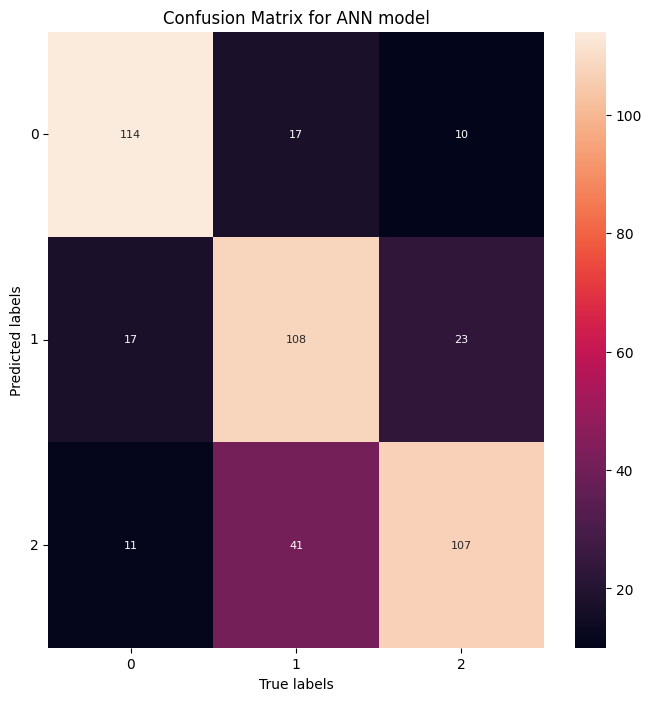

In [ ]:
predictions = ann.predict(x_test)

y_pred = np.argmax(predictions, axis=1)

y_true = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_pred=y_pred, y_true=y_true)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8})

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix for ANN model') 
plt.yticks(rotation=0)
plt.show()


Here I choose to visualise the overall accuracy and loss per class accuracy, meaning how well the model predicted for each class. As we can see the overall accuracy was 73.44%, but as a high as 80.85% for sports but only 67.30% for science

In [184]:


test_loss, test_accuracy = ann.evaluate(x_test, y_test)
accuracy_prob = test_accuracy * 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy_prob:.2f}%")


per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"For {unique_categories[i]} accuracy was: {acc:.2%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7344 - loss: 0.7652
Test Loss: 0.7652
Test Accuracy: 73.44%
For football accuracy was: 80.85%
For politics accuracy was: 72.97%
For science accuracy was: 67.30%


Now we can create are second model the CNN model. In order to train a CNN model it has to be a matrix instead of a row, hence I needed to add a dimension which I done with the reshape function in Python. The updated shapes is (1045, 300, 1) for the trainin data and (448, 300, 1) for the test data. Which mean that we have 1045 samples of a 300 x 1 matrix in the training data and 448 samples of  300x1 matrix in the testing data

In [116]:
x_train_cnn = x_train.values.reshape(-1, 300, 1)
x_test_cnn = x_test.values.reshape(-1, 300, 1)

print(f'The traning data has the following shapes: {x_train_cnn.shape}')
print(f'The traning data has the following shapes: {x_test_cnn.shape}')

The traning data has the following shapes: (1045, 300, 1)
The traning data has the following shapes: (448, 300, 1)


The model arcitecture consits of an input layer where I defined the shapes printed above. Since this is 1D just one row, I use the CNN layers for 1D. I started with a 64 filters a 3 kernel, activation of relu and the same padding, which are all arbitrary values common in CNN arcitecture. I then employed a maxpooling layer in 1D and pool size which will only captue half the columns of words. I then used a dropout layer of 10%. 

I then made a second CNN layer with conv1D with half the size and the same pooling and dropout layer. Then I need to use flatten layer to remove the dimension we added in order to get a prediction. Then I gave it to a dense layer of three hidden units with the softmax function because we have 3 different categories. 

The described arcitecture can be seen in the model summary below. 

In [216]:
cnn = tf.keras.Sequential([
    layers.Input(shape=(x_train_cnn.shape[1], 1)),
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.1),

    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(3, activation='softmax')
])

cnn.compile(optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

cnn.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 300, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 150, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │       153,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,883 (698.76 KB)

 Trainable params: 178,883 (698.76 KB)

 Non-trainable params: 0 (0.00 B)

Here I train the model with the reshaped tarining data and its corresponding labels. For a fair comparasion the epochs is the same as the once used to train the ANN model

In [217]:
history=cnn.fit(x_train_cnn, y_train, epochs=50)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5455 - loss: 0.9201
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6756 - loss: 0.7062
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7512 - loss: 0.5873
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7952 - loss: 0.4868
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8316 - loss: 0.4167
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8565 - loss: 0.3486
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8689 - loss: 0.3064
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8804 - loss: 0.2865
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8986 - loss: 0.2502
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9158 - loss: 0.2149
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9177 - loss: 0.2034
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9244 - lo

Once again to visualisation the model predicition over all classes I made a confusion matrix. The result can be seen below

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


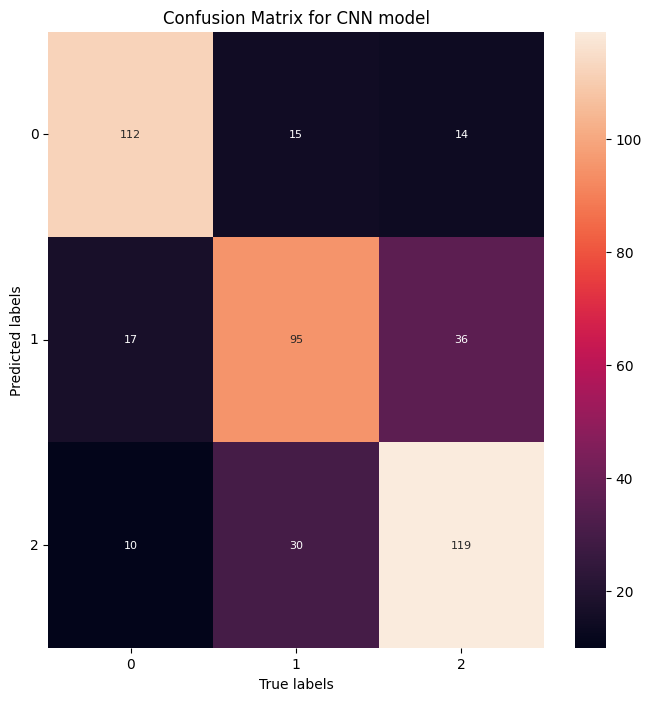

In [218]:
predictions = cnn.predict(x_test_cnn)

y_pred = np.argmax(predictions, axis=1)

y_true = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_pred=y_pred, y_true=y_true)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8})

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix for CNN model') 
plt.yticks(rotation=0)
plt.show()


Below I print the accuracy and loss on the test dataset as well as the per class accuracy. As we can see the model had an overall accuracy if 72.77% with the best accuracy for football and the worst being polictics, the same pattern as for the ANN model. 

In [219]:
test_loss, test_accuracy = cnn.evaluate(x_test, y_test)
accuracy_prob = test_accuracy * 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy_prob:.2f}%")


per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"For {unique_categories[i]} accuracy was: {acc:.2%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 2.1388 
Test Loss: 2.1388
Test Accuracy: 72.77%
For football accuracy was: 79.43%
For politics accuracy was: 64.19%
For science accuracy was: 74.84%


Now it is yime to train the third model which is the LSTM. The LSTM can be trained on the same data as the ANN model. 

The model arcitecture consists of the input layer which is the same as the CNN. Then we have a LSTM layer with 128 hidden units a specified dropout and tanh as the activation function, which comes from experience. We also have the return_sequence set to true because the second layer needs a sequence and not a vector which is other wise the case. Then we have a second LSTM layer with half the amount of hidden units but otherwise the same configuration. Then we need a flatten layer because the return sequence is true. Then we have 2 dense layer, the first being arbitrary amount of hidden units and the relu activation function and the second having 3 hidden units and the softmax because we have 3 categories. 

The described model can be seen below in the model summary.

In [251]:
lstm = tf.keras.Sequential([
    layers.Input(shape=(x_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True, dropout=0.2, activation='tanh'),
    layers.LSTM(64, activation='tanh', dropout=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

lstm.compile(optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

lstm.summary()

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 300, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,147 (461.51 KB)

 Trainable params: 118,147 (461.51 KB)

 Non-trainable params: 0 (0.00 B)

In [252]:
history = lstm.fit(x_train, y_train, epochs=50)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.3522 - loss: 1.0973
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3742 - loss: 1.0896
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3971 - loss: 1.0890
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.4048 - loss: 1.0656
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4411 - loss: 1.0448
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4411 - loss: 1.0290
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4632 - loss: 1.0140
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4536 - loss: 1.0100
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4632 - loss: 1.0097
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4517 - loss: 1.0198
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4488 - loss: 1.0127
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy:

A heatmap of the models prediction on the test dataset. 

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


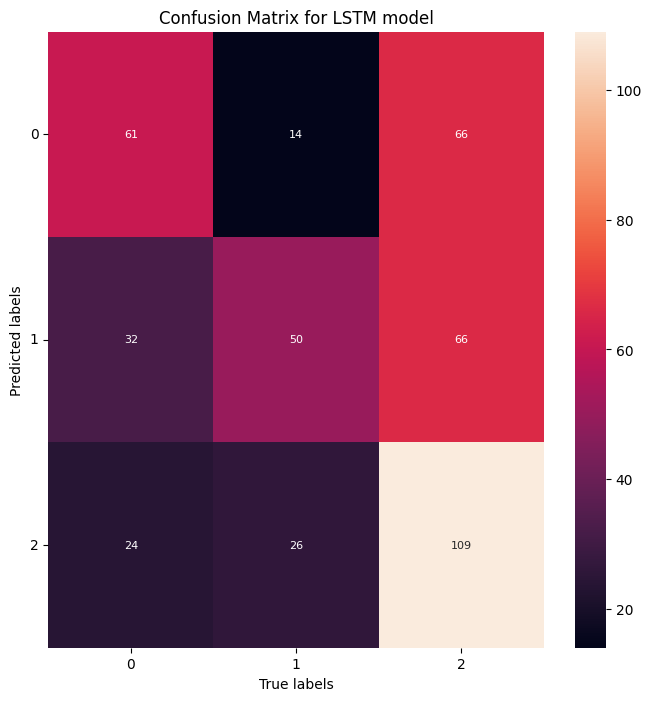

In [253]:
predictions = lstm.predict(x_test)

y_pred = np.argmax(predictions, axis=1)

y_true = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_pred=y_pred, y_true=y_true)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8})

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix for LSTM model') 
plt.yticks(rotation=0)
plt.show()


This is the accuracy and loss for the LSTM model and per class accuracy. As we can see the model is best at predicting the science class but worst at precitcintg politcs. 

In [254]:
test_loss, test_accuracy = lstm.evaluate(x_test, y_test)
accuracy_prob = test_accuracy * 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy_prob:.2f}%")


per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"For {unique_categories[i]} accuracy was: {acc:.2%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4911 - loss: 1.0016
Test Loss: 1.0016
Test Accuracy: 49.11%
For football accuracy was: 43.26%
For politics accuracy was: 33.78%
For science accuracy was: 68.55%


Final evaluation: 


The ANN model had an overall accuracy of 73,44%, a loss of 0.7652 and a training time of 1.4 seconds. 

For the CNN model the corresponding stats are a accuracy of 72.77%, a loss of 2.1388 and a training time of 8.9 seconds. 

Lastly, the LSTM model had an overall accuracy of 49.11%, a loss of 1.0016 and 2 minutes and 4.8 seconds training time. 

Based on the result I would the ANN model is the best. It has the highest accuracy, lowest loss and fastest training time. If you compare the output from the confusion matrix the ANN also has somewhat lower variance the the CNN model as seen from the per-class accuracy shown below:


Ann:
For football accuracy was: 80.85%
For politics accuracy was: 72.97%
For science accuracy was: 67.30%

Cnn 
For football accuracy was: 79.43%
For politics accuracy was: 64.19%
For science accuracy was: 74.84%


To summarize, all models are performing quite bad, especially the LSTM model which has the lowest accuracy and highest training time. The reason for this is how the data is structured. Since we only know which words are in an article but not the order the data is not sequential which is not what LSTM models are suppose to do and the reason for its bad performance. Although the CNN clearly outperformed the LSTM model, CNN are also not built for this type of data. CNN performs best on images and are more suited for tasks object detection classification rather than classification of articles. For this specific task a simple ANN model like the one built here is the one I would expect to perform best just based on the type of data used. 



